In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from scipy.stats import levene

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['ps.useafm'] = True

In [4]:
def plot_bar_with_sem(dataframes, file_paths, ydown, yup, column='30', output_file='FacTetherNoCross-HetRatios.pdf'):

    group1 = dataframes[0][column].dropna()
    group2 = dataframes[1][column].dropna()
    group3 = dataframes[2][column].dropna()

    levene_stat, levene_p = levene(group1, group2, group3)

    if len(dataframes) == 6:
        
        group4 = dataframes[3][column].dropna()
        group5 = dataframes[4][column].dropna()
        group6 = dataframes[5][column].dropna()

        levene_stat, levene_p = levene(group1, group2, group3, group4, group5, group6)

    print(f'Levene Test for Homogeneity of Variance: {levene_stat:.3f}, p-value: {levene_p:.3f}')

    if levene_p > 0.05:
        print("Homogeneity of variance assumption is satisfied.")

    groups = [group1, group2, group3]

    if len(dataframes) == 4:
        groups.append(group4)

    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            stat, p_value = ttest_ind(groups[i], groups[j])
            print(f'T-statistic (Group {i + 1} vs Group {j + 1}): {stat}, p-value: {p_value}')
            t_test_result = "significant" if p_value <= 0.05 else "no significant"
            print(f"There is {t_test_result} difference between Group {i + 1} and Group {j + 1}.")

    data = np.concatenate([group1, group2, group3])
    labels = ['Case 1'] * len(group1) + ['Case 2'] * len(group2) + ['Case 3'] * len(group3)

    if len(dataframes) == 4:

        data = np.concatenate([group1, group2, group3, group4])
        labels = ['Case 1'] * len(group1) + ['Case 2'] * len(group2) + ['Case 3'] * len(group3) + ['Case 4'] * len(group4) + ['Case 5'] * len(group5) + ['Case 6'] * len(group6)

    df = pd.DataFrame({'Value': data, 'Group': labels})

    anova = ols('Value ~ Group', data=df).fit()
    anova_table = sm.stats.anova_lm(anova, typ=2, test='F')
    print("ANOVA Results:")
    print(anova_table)

    if anova_table['PR(>F)'][0] < 0.05:

        tukey = pairwise_tukeyhsd(df['Value'], df['Group'])
            
        significance = [''] * len(tukey._results_table.data[1:])

        summary = tukey.summary()

        for ind, row in enumerate(summary.data[1:]):  

            group1, group2, meandiff, pval, lower, upper, reject = row

            formatted_pval = f"{pval:.3e}" if pval > 1e-15 else "< 1e-15"  

            if pval < 0.001:
                significance[ind] = '***'

            elif pval < 0.01:
                significance[ind] = '**'

            elif pval < 0.05:
                significance[ind] = '*'

            print(f"{group1} vs {group2}: Mean Difference = {meandiff:.3f}, p-value = {formatted_pval}, "
                f"95% CI: ({lower:.3f}, {upper:.3f}), Reject Null: {reject}, Significance: {significance[ind]}")

        for comparison in tukey._results_table.data[1:]:
            
            group1, group2, meandiff, pval, lower, upper, reject = comparison

            formatted_pval = f"{pval:.3e}" if pval > 1e-15 else "< 1e-15" 

    means = [df[column].mean() for df in dataframes]
    sems = [df[column].sem() for df in dataframes]
    data_points = [df[column].dropna() for df in dataframes]

    plt.figure(figsize=(6, 6))
    x_positions = np.arange(len(means))

    plt.bar(
        x_positions,
        means,
        yerr=sems,
        capsize=10,
        alpha=1,
        color=['skyblue', 'lightgreen', 'salmon'],
        tick_label=[file_paths[i].split('/')[-1].split('_')[2] for i in range(len(means))],
        width=0.6
    )

   
    plt.ylim(ydown, yup)
    plt.xlabel("DataFrames")
    plt.ylabel(f"Values ({column} Column)")
    plt.title(f"Bar Plot with SEM for '{column}' Column")
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()


Levene Test for Homogeneity of Variance: 1.529, p-value: 0.235
Homogeneity of variance assumption is satisfied.
T-statistic (Group 1 vs Group 2): 1.7356612120476569, p-value: 0.09971061783163322
There is no significant difference between Group 1 and Group 2.
T-statistic (Group 1 vs Group 3): 2.26906091863935, p-value: 0.035796013038351115
There is significant difference between Group 1 and Group 3.
T-statistic (Group 2 vs Group 3): 1.0937720665303345, p-value: 0.2884768089049203
There is no significant difference between Group 2 and Group 3.
ANOVA Results:
               sum_sq    df         F    PR(>F)
Group      556.026552   2.0  3.447428  0.046409
Residual  2177.379441  27.0       NaN       NaN
Case 1 vs Case 2: Mean Difference = -6.452, p-value = 2.602e-01, 95% CI: (-16.410, 3.505), Reject Null: False, Significance: 
Case 1 vs Case 3: Mean Difference = -10.450, p-value = 3.830e-02, 95% CI: (-20.407, -0.492), Reject Null: True, Significance: *
Case 2 vs Case 3: Mean Difference = -3.

/var/folders/8k/t2v98c256ngb4cr7j7p5m8100000gn/T/ipykernel_38896/2173851741.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


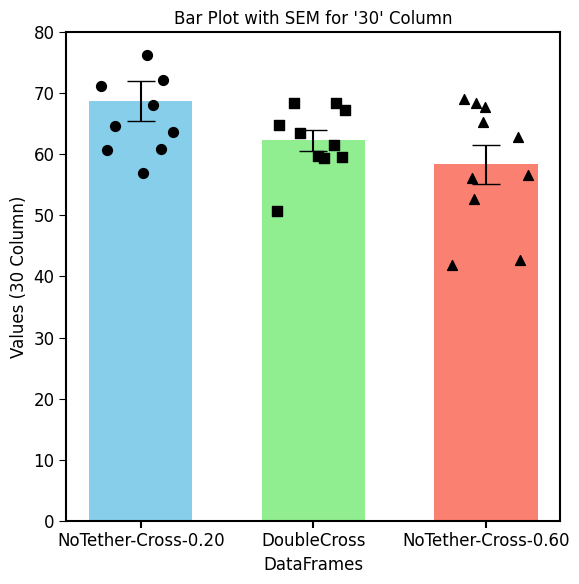

In [220]:
file_paths = [
    "/Users/attar/Desktop/ksprings/NoTether/ksprings_30_NoTether-Cross-0.20_aattar.csv",
    "/Users/attar/Desktop/ksprings/NoTether/ksprings_30_DoubleCross_NoTether.csv",
    "/Users/attar/Desktop/ksprings/NoTether/ksprings_30_NoTether-Cross-0.60_aattar.csv"
]

dataframes = [pd.read_csv(file_path, delimiter='\t', header=None) for file_path in file_paths]

for df in dataframes:
    df.columns = ['10', '20', '30', '40', '50']
    
    df[df < 0] = np.nan

plot_bar_with_sem(dataframes, file_paths, column='30', output_file='Figure3_NoCross_TetherComp_HetRatio.pdf')